# Decoding workshop

The action potentials emitted by neurons are usually seen as the most elementary processing unit in the brain. In rodents, for example, one can have neurons that fire their action potentials for very elementary features such as orientation, color and position of a visual stimulus, or more abstract ones, such as being or not in the nest and the animal position.

The existence of such neuronal activity correlates leads to the idea that, somehow, the external stimulus are ‘encoded’ in the neuronal spikes, and we use them to perceive the world. With this in mind, we can think that a good way to investigate how this stimulus ‘encoding’ is done is trying to do the reverse operation. In order words, to use some measured neuronal activity to decode an external known feature/stimulus. That is what we are going to do in this assignment.

For that, we are going to use a Support Vector Machine classifier.


## Part 1 – Simulating our data

To understand the initial steps of neuronal decoding we are first going to use some simulated data. Suppose that the neural activity (i.e., spikes) of an animal is modulated by a given stimulus. Because later on we are going to use some real data using sound stimulation, let’s consider that we have two sound stimuli and each sound is repeated 25 times. Each sound have a duration of 2 seconds and are presented in intervals of 5 seconds.

We first import the libraries we are going to use in python:

In [27]:
import numpy as np
from matplotlib import pyplot as plt

### Creating the neuron firing rate profiles
We will first modulate the activity of 20 neurons as an in-homogeneous Poisson process. Each neuron will have it’s mean firing rate drawn from a random exponential distribution with mean 5.

In [3]:
n_cells = 20
n_stim_type = 2

average_firing_rate = 5 # the peak firing rate, averaged across the population

In [14]:
rng = np.random.default_rng(12345)
cell_rate_baseline = rng.exponential(average_firing_rate,(1,n_cells))

### Implementing changes in firing rate during stimulus
Also, the mean firing rate of each neuron will be modulated by a multiplicative factor during the stimuli presentation, drawn from a normal distribution with mean 1 and 0.5 std.

In [19]:
modulation = (1+ 0.5*rng.normal(0,1,(1,n_cells)))

cell_rate_stim1 = cell_rate_baseline*modulation

To simplify, we are going to use opposite modulations for the different stimuli. In other words, if stim 1 is modulated by 1.2, stim 2 is modulated by 0.8.

In [20]:
cell_rate_stim2 = cell_rate_baseline*(2-modulation)

cell_rate = np.zeros((n_cells,2,n_stim_type))

cell_rate[:,0,0] = cell_rate_baseline
cell_rate[:,0,1] = cell_rate_baseline

cell_rate[:,1,0] = cell_rate_stim1
cell_rate[:,1,1] = cell_rate_stim2


This is to guarantee that no neuron has a negative firing rate in case we get any modulation value higher than 2.

In [23]:
cell_rate[cell_rate<0] = 0


Let's look to how the firing rate of our neurons will behave:

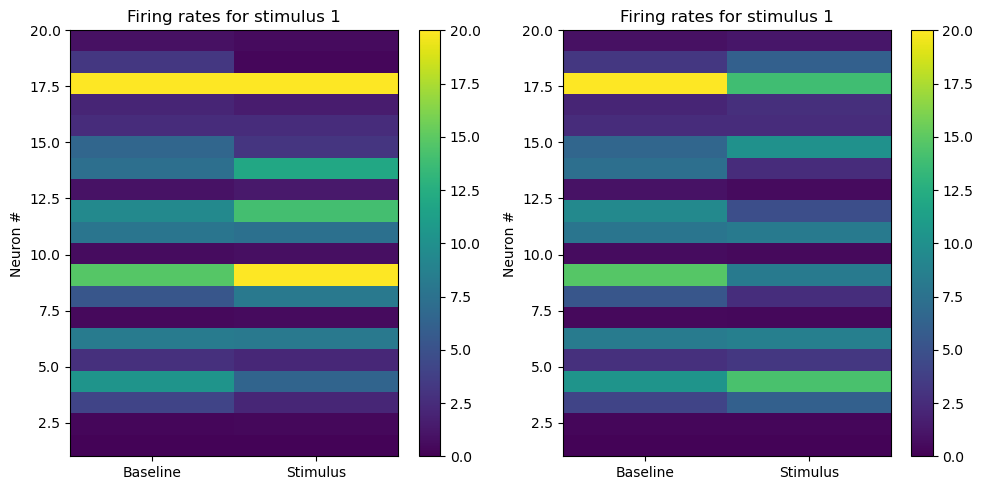

In [64]:

plt.figure(1,(10,5))
plt.subplot(1,2,1)
plt.imshow(np.squeeze(cell_rate[:,:,0]), extent = [0, 2, 1, n_cells],vmin=0,vmax=20, aspect='auto')
plt.xticks([0.5,1.5],['Baseline', 'Stimulus'])
plt.ylabel('Neuron #')
plt.title('Firing rates for stimulus 1')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.squeeze(cell_rate[:,:,1]), extent = [0, 2, 1, n_cells],vmin=0,vmax=20, aspect='auto')
plt.xticks([0.5,1.5],['Baseline', 'Stimulus'])
plt.ylabel('Neuron #')
plt.title('Firing rates for stimulus 1')
plt.colorbar()

plt.show()

Simulating stimulus

In [90]:
srate = 10000 # the sampling rate of our emulated recording system
noise_rate = 1 # we are going to add some spike noise non related to the task
n_stim = 100 # number of stimuli

stim_dur = 2 # stimulus duration (in seconds)
stim_interval = 5 # interval between stimuli (in seconds)

#  1:stim_interval:stim_interval*n_stim;
stim_times = np.arange(1,stim_interval*n_stim,stim_interval) # time of each stimulus (in seconds)
stim_type = np.squeeze(np.concatenate((np.zeros((1,int(n_stim/2))), np.ones((1,int(n_stim/2)))),axis=1)) # identity of each stimulus


ttime=max(stim_times)+stim_interval # total recorded time
time = np.arange(0,ttime,1/srate) # time vector of the sampled times.


In [122]:
spktimes=[]
for icell in np.arange(n_cells):

    # Creating the spikes with the baseline firing rate
    spikes  = rng.poisson(cell_rate[icell,0,0]/srate, (1,len(time)))
#     spikes = poissrnd(cell_rate(icell,1,1)/srate,[1,length(time)]);

    for itype in np.arange(n_stim_type):
        # find the indexes of each of the stimulus
        trialidx = stim_type == itype

        # for those indexes, get the stimulus start time
        for stim_start in stim_times[trialidx]:

            # from the start of the stimulus until it's duration we use a
            # different firing rate for the poisson process, which depends
            # on the stimulus type.
            idx = np.where(np.logical_and(time>stim_start, time<=stim_start+stim_dur))[0]
            spikes[0,idx] = rng.poisson(cell_rate[icell,1,itype]/srate, (1,len(idx)))

    # at last we add the spike noise
    
    spikes = spikes + rng.poisson(noise_rate/srate, (1,len(time)))

    idx = spikes>0
    spktimes.append(time[idx[0,:]])

Now we have some time series very similar to what we would get in a real experiment. The timestamps of each neuronal spikes (SPKTIMES), and the  stimuli time (STIM_TIMES) and type (STIM_TYPE). Let's save this data, and go on from the next script.

In [129]:
np.save('simulated_data1',[spktimes,stim_type,stim_times,srate],allow_pickle=True)